In [19]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [20]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from cobra.io import read_sbml_model
from utils.cobra_utils import get_or_create_exchange, set_active_bound

# Load the model
model = read_sbml_model("../model/Rpom_05.xml")
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Get CO2 molecules, for use later
co2_e = model.metabolites.get_by_id("CARBON-DIOXIDE[e]")
co2_p = model.metabolites.get_by_id("CARBON-DIOXIDE[p]")
co2_c = model.metabolites.get_by_id("CARBON-DIOXIDE[c]")

# TODO: Remove all of the below
# Turn on maintenance
atpm = model.reactions.get_by_id("ATPM")
atpm.bounds = (25, 25)

In [22]:
# Load pathway data
import pickle

with open("../model_building/pathway_data.pkl", "rb") as f:
    pathway_data = pickle.load(f)

In [23]:
# Get solutions on glucose and acetate

with model:
    ex_glc.bounds = (-10, 0)
    ex_ace.bounds = (0, 0)
    sol_glc = model.optimize()

with model:
    ex_glc.bounds = (0, 0)
    ex_ace.bounds = (-10, 0)
    sol_ace = model.optimize()

# Normalize fluxes
glc_fluxes = sol_glc.fluxes / sol_glc.objective_value
ace_fluxes = sol_ace.fluxes / sol_ace.objective_value

In [24]:
# Selected from top flux pathways (see below)

pathways_of_interest = [
    "ANAGLYCOLYSIS-PWY",  # Glycolysis

    "PWY0-1313",  # acetate conversion to acetyl-CoA
    "PWY-5741",  # Ethylmalonyl-CoA pathway
    "TCA",  # TCA cycle
    "PWY-8004",  # Entner-Doudoroff pathway I
    "PWY-3781",  # aerobic respiration I (cytochrome c)
    
    "PWY-7980",  # ATP biosynthesis
    "PWY-8303",  # reductive glycine pathway of autotrophic CO2 fixation
    "PROPIONMET-PWY",  # propanoyl CoA degradation I
    # "FAO-PWY",  # fatty acid β-oxidation I (generic)
    "PWY0-1337",  # oleate β-oxidation
    "GLUTDEG-PWY",  # L-glutamate degradation II
    "1CMET2-PWY",	# folate transformations III (E. coli)
    "PWY-1722",  # formate assimilation into 5,10-methylenetetrahydrofolate
    "PWY-1881",  # formate oxidation to CO2
    "PWY-8291",  # L-aspartate degradation II (aerobic)
    "PWY-6613",  # tetrahydrofolate salvage from 5,10-methenyltetrahydrofolate
    # "PWY-8279",  # palmitate biosynthesis III
    # "PWY-8280",  # stearate biosynthesis IV  (likely dupe of above)
    # "PWY-7388",  # octanoyl-[acyl-carrier protein] biosynthesis (mitochondria, yeast)
    "SERSYN-PWY",  # L-serine biosynthesis I
    "PWY-2161",  # folate polyglutamylation
    "PWY1-3",  # polyhydroxybutanoate biosynthesis
    # "PYRIDOXSYN-PWY",  # pyridoxal 5'-phosphate biosynthesis I
    # "PHESYN",  # L-phenylalanine biosynthesis I
    # "TYRSYN",  # L-tyrosine biosynthesis I
    "ASPARTATE-DEG1-PWY",  # L-aspartate degradation I
    # "PWY-6638",  # sulfolactate degradation III
    # "PWY-5329",  # L-cysteine degradation III
    # "PWY-5886",  # 3-(4-hydroxyphenyl)pyruvate biosynthesis
    "GLYSYN-PWY",  # glycine biosynthesis I
    "UDPNAGSYN-PWY",  # UDP-N-acetyl-D-glucosamine biosynthesis I
    # "FASYN-ELONG-PWY",  # fatty acid elongation -- saturated
]

In [25]:
# Utility function to draw a vertical bracket using data coordinates
def vbracket(ax, x, bracket_width, text_offset, y, height=0.1, lw=1, text=None):
    top = y + height / 2
    bottom = y - height / 2
    mid = x + bracket_width
    right = mid + text_offset

    ax.plot([x, mid, mid, x], [top, top, bottom, bottom],
            color="black",
            lw=lw,
            clip_on=False)
    # ax.plot([x1, x1, x2, x2], [y, y + height, y + height, y], color="black", clip_on=False)
    if text is not None:
        ax.text(right, y, text, ha="left", va="center")


# Utility function to get total CO2 coefficient of a reaction
def get_co2_coeff(reaction):
    co2 = 0
    for met, coeff in reaction.metabolites.items():
        if met == co2_e or met == co2_p or met == co2_c:
            co2 += coeff
    return co2

In [ ]:
# Get flux directions under glucose, treating reactions with zero flux as forward (1)
glc_directions = np.sign(glc_fluxes).replace(0, 1)

1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN    1.0
1.1.1.178-RXN                          1.0
1.1.1.262-RXN                          1.0
1.1.1.39-RXN                           1.0
1.1.1.8-RXN                            1.0
                                      ... 
CYTOCHROME-C-PEROXIDASE-RXN            1.0
CYTOCHROME-C-OXIDASE-RXN               1.0
1.10.2.2-RXN                           1.0
Citrate-transport                      1.0
3-Hydroxybutyrate-transport            1.0
Name: fluxes, Length: 1968, dtype: float64

In [60]:
plot_fluxes.index

Index(['1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN', '1.1.1.178-RXN', '1.1.1.262-RXN',
       '1.1.1.39-RXN', '1.1.1.8-RXN', '1.13.11.15-RXN', '1.13.11.25-RXN',
       '1.13.11.6-RXN', '1.14.11.1-RXN', '1.2.1.2-RXN',
       ...
       'RXN-11951', 'RXN-11952', 'RXN-18796', 'RXN-18797', 'RXN-18798',
       'CYTOCHROME-C-PEROXIDASE-RXN', 'CYTOCHROME-C-OXIDASE-RXN',
       '1.10.2.2-RXN', 'Citrate-transport', '3-Hydroxybutyrate-transport'],
      dtype='object', length=1967)

(45, 2)


/tmp/ipykernel_25597/648598197.py:206: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


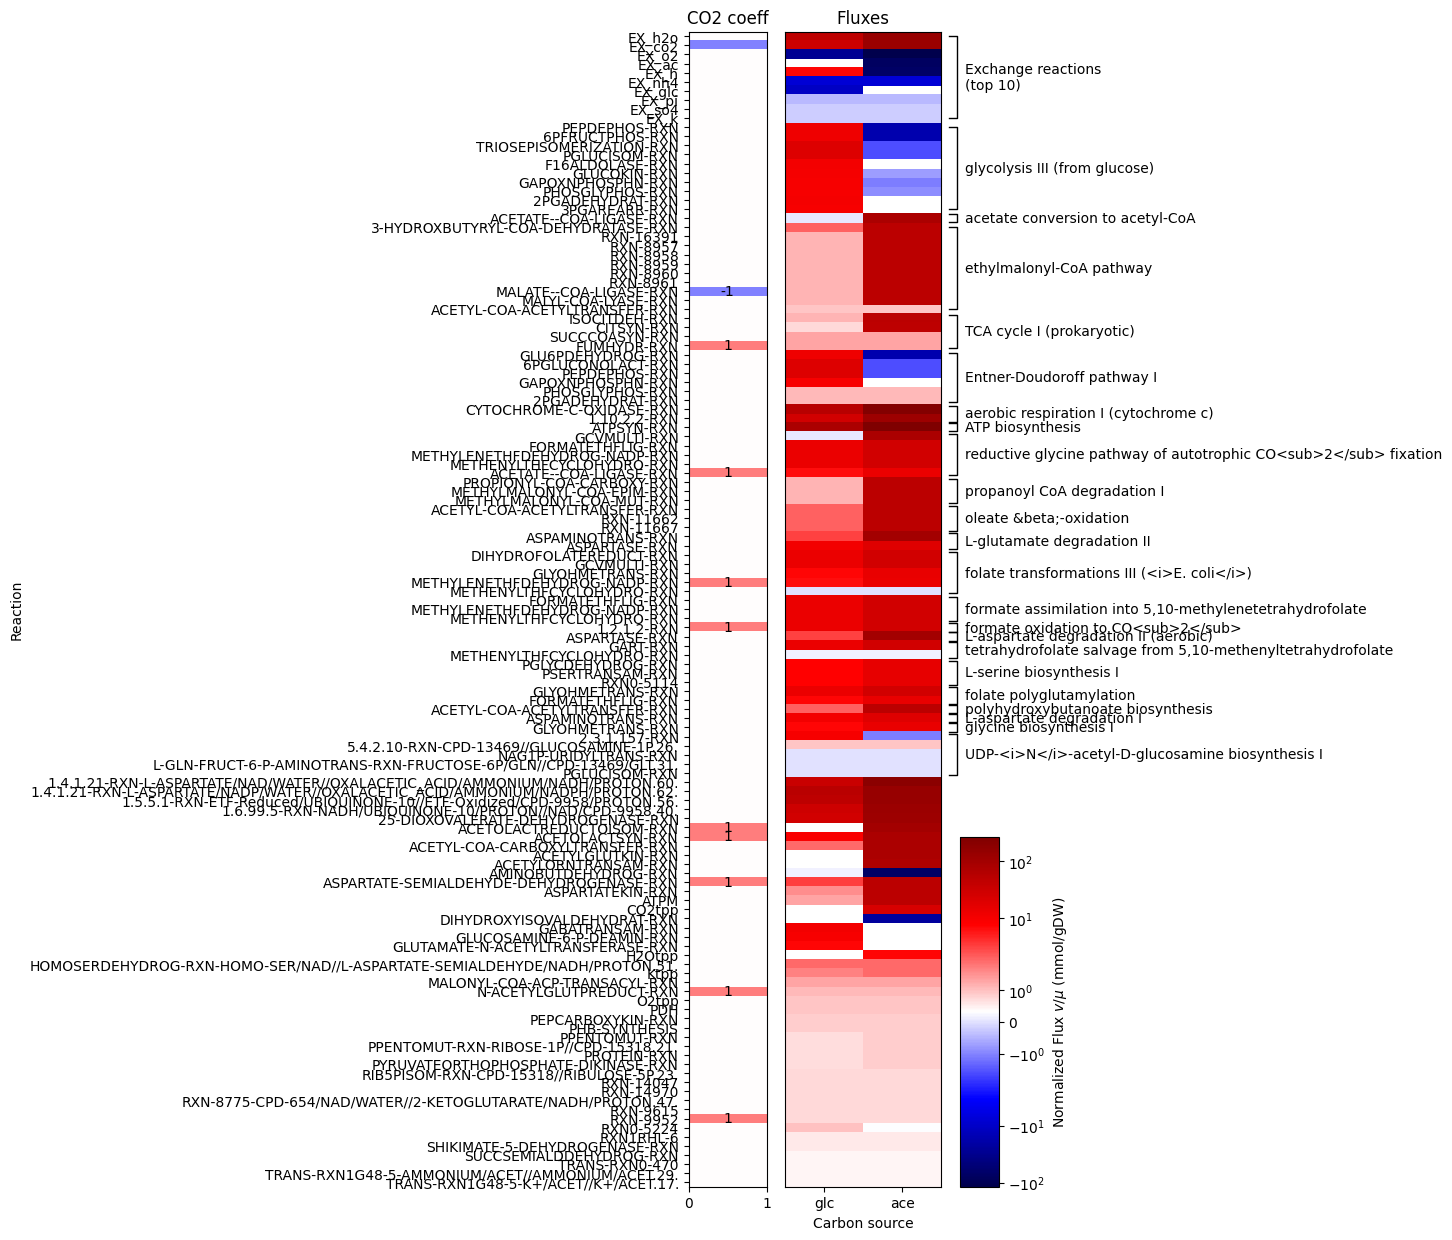

In [ ]:
# Merge glc_fluxes and ace_fluxes into a dataframe
plot_fluxes = pd.DataFrame({"glc": glc_fluxes, "ace": ace_fluxes})

# Exclude biomass flux
plot_fluxes = plot_fluxes.drop("Rpom_hwa_biomass")

# EXCEPT FOR EXCHANGE REACTIONS, treat the direction under glucose as the canonical direction of the reaction
# (so as to highlight differences). If there is no flux, use the curated direction as "forward"
# glc_directions = np.sign(glc_fluxes).replace(0, 1)
exchange_ids = [ex.id for ex in model.exchanges]
glc_directions = np.array([np.sign(flux) if (flux != 0 and rxn not in exchange_ids) else 1.0
                           for rxn, flux in zip(plot_fluxes.index, plot_fluxes["glc"])])
# plot_fluxes["glucose_direction"] = glc_directions
plot_fluxes["glc"] *= glc_directions
plot_fluxes["ace"] *= glc_directions

# Exclude external metabolite transport reactions (__tex), since
# their behavior is explained by the exchange reactions
# (Including periplasmic transport, __tpp, because periplasmic metabolites sometimes have unique reactions)
plot_fluxes = plot_fluxes[~plot_fluxes.index.str.endswith("tex")]

# Take absolute values, sort by flux difference, then by total flux, then by total absolute flux
# plot_fluxes = plot_fluxes.abs()
plot_fluxes["diff"] = np.abs(plot_fluxes["glc"] - plot_fluxes["ace"])
plot_fluxes["total"] = plot_fluxes["glc"] + plot_fluxes["ace"]
plot_fluxes["abs_total"] = np.abs(plot_fluxes["glc"]) + np.abs(plot_fluxes["ace"])
plot_fluxes = plot_fluxes.sort_values("diff", kind="stable")
plot_fluxes = plot_fluxes.sort_values("total", kind="stable")
plot_fluxes = plot_fluxes.sort_values("abs_total", kind="stable")
plot_fluxes = plot_fluxes.drop("diff", axis=1)
plot_fluxes = plot_fluxes.drop("total", axis=1)
plot_fluxes = plot_fluxes.drop("abs_total", axis=1)

# Filter reactions that always have zero flux, and set remaining zeros to NaN
plot_fluxes = plot_fluxes[(plot_fluxes != 0).any(axis=1)]
plot_fluxes = plot_fluxes.replace(0, np.nan)

# Get min and max values for color scaling
f_min = plot_fluxes.min().min()
f_max = plot_fluxes.max().max()

abs_co2_coeffs = [abs(get_co2_coeff(rxn)) for rxn in model.reactions]
c_max = max(abs_co2_coeffs)
c_min = -c_max

# Plot the fluxes!! =============================================================================================
OFFSET = 0.1
SHOW_RXN_NAMES = True
MAX_N_ADDITIONAL = 100  # Number of reactions to plot after the pathways of interest (upper bound, since already-plotted reactions are dropped.)
cmap="seismic"

# fig, (ax1, ax2) = plt.subplots(1, 3, sharey=True, gridspec_kw={"width_ratios": [1, 2]})
# fig, axs = plt.subplot_mosaic([["co2", "fluxes", "_"],
#                                ["co2", "fluxes", "cax"]],
#                             #    sharey=True,
#                                gridspec_kw={"width_ratios": [2, 4, 1], "height_ratios": [2, 1]})
# ax1 = axs["co2"]
# ax2 = axs["fluxes"]
# cax = axs["cax"]

fig = plt.figure()
gs = GridSpec(2, 3, figure=fig, width_ratios=[2, 4, 1], height_ratios=[2, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1], sharey=ax1)
cax = fig.add_subplot(gs[1, 2])

# Hide spacing axis
# axs["_"].axis("off")

# First, plot exchange reactions separately
pos = 0
yticks = []
plotted_reactions = set()

exchange_ids = [ex.id for ex in model.exchanges]
for rxn in reversed(plot_fluxes.index):
    if rxn not in exchange_ids:
        continue
    # Skip if flux is always < 0.01
    if plot_fluxes.loc[rxn].abs().max() < 0.01:
        continue
    
    # Plot CO2 coefficient
    ax1.imshow([[get_co2_coeff(model.reactions.get_by_id(rxn))]],
               cmap=cmap,
               aspect="auto",
               extent=(0, 1, pos, pos + 1),
               interpolation="none",
               vmin=c_min,
               vmax=c_max)

    # Plot fluxes
    ax2.imshow(plot_fluxes.loc[[rxn]],
                cmap=cmap,
                aspect="auto",
                extent=(0, 2, pos, pos + 1),
                interpolation="none",
                vmin=f_min,
                vmax=f_max,
                norm="symlog")
    yticks.append(rxn)
    plotted_reactions.add(rxn)
    pos += 1
vbracket(ax2, 2 + OFFSET, OFFSET, OFFSET, pos / 2, 0.9 * pos, text=f"Exchange reactions\n(top {pos})")

# First, plot fluxes from pathways of interest separately
for pathway in pathways_of_interest:
    
    # Pull out the reactions in the pathway
    rxns_in_pwy = []
    for rxn in plot_fluxes.index:
        pwys = model.reactions.get_by_id(rxn).notes.get("pathways", [])
        if isinstance(pwys, str):
            pwys = [pwys]
        
        if pathway in pwys:
            rxns_in_pwy.append(rxn)

    # Plot CO2 coefficients
    co2_coeffs = [[get_co2_coeff(model.reactions.get_by_id(rxn))] for rxn in rxns_in_pwy]
    ax1.imshow(co2_coeffs,
               cmap=cmap,
               aspect="auto",
               extent=(0, 1, pos, pos + len(rxns_in_pwy)),
               interpolation="none",
               vmin=c_min,
               vmax=c_max)
    for i, coeff in enumerate(reversed(co2_coeffs)):
        ax1.text(0.5, pos + i + 0.5, f"{int(coeff[0]) if coeff[0] != 0 else ''}", ha="center", va="center")
    
    # Plot the fluxes
    ax2.imshow(plot_fluxes.loc[rxns_in_pwy],
              cmap=cmap,
              aspect="auto",
              extent=(0, 2, pos, pos + len(rxns_in_pwy)),
              interpolation="none",
              vmin=f_min,
              vmax=f_max,
              norm="symlog")
    
    # Label the pathway
    vbracket(ax2,
             2 + OFFSET,
             OFFSET,
             OFFSET,
             pos + len(rxns_in_pwy) / 2,
             0.9 * len(rxns_in_pwy),
             text=pathway_data[pathway]["common-name"])

    pos += len(rxns_in_pwy)
    yticks.extend(rxns_in_pwy)
    plotted_reactions |= set(rxns_in_pwy)

# Filter the remaining to select top 100 fluxes,
# dropping the ones that have already been plotted
plot_fluxes = plot_fluxes[-MAX_N_ADDITIONAL:]
plot_fluxes = plot_fluxes.drop(list(plotted_reactions), errors="ignore")
print(plot_fluxes.shape)

# Then, plot the rest

# Plot CO2 coefficients
co2_coeffs = [[get_co2_coeff(model.reactions.get_by_id(rxn))] for rxn in plot_fluxes.index]
ax1.imshow(co2_coeffs,
            cmap=cmap,
            aspect="auto",
            extent=(0, 1, pos, pos + len(plot_fluxes)),
            interpolation="none",
            vmin=c_min,
            vmax=c_max)
# Add co2 coeff labels
for i, coeff in enumerate(reversed(co2_coeffs)):
    ax1.text(0.5, pos + i + 0.5, f"{int(coeff[0]) if coeff[0] != 0 else ''}", ha="center", va="center")

# Fluxes
mappable = ax2.imshow(plot_fluxes,
          cmap=cmap,
          aspect="auto",
          extent=(0, 2, pos, pos + len(plot_fluxes)),
          interpolation="none",
          vmin=f_min,
          vmax=f_max,
          norm="symlog")
yticks.extend(plot_fluxes.index.difference(plotted_reactions))

ax2.set_xticks([0.5, 1.5], ["glc", "ace"])
if SHOW_RXN_NAMES:
    ax1.set_yticks(0.5 + np.arange(len(yticks)), yticks)
    # turn off axis 2 ticks
    ax2.tick_params(axis="y", which="both", left=False, labelleft=False)
else:
    ax1.set_yticks([])
    ax2.set_yticks([])
ax2.set_ylim(0, pos + len(plot_fluxes))
ax2.invert_yaxis()

# Labels
ax1.set_ylabel("Reaction")
ax2.set_xlabel("Carbon source")
ax1.set_title("CO2 coeff")
ax2.set_title("Fluxes")

# Draw colorbar into cax
fig.colorbar(mappable, cax=cax, label="Normalized Flux $v/\\mu$ (mmol/gDW)")

fig.tight_layout()
fig.set_size_inches(4,15)

Version with transcriptomic fold-changes instead of CO2 coefficients

Expanding to full substrate set

In [27]:
print(model.medium)

{'EX_ca2': 1000.0, 'EX_cl': 1000.0, 'EX_co2': 1000.0, 'EX_cobalt2': 1000.0, 'EX_cu2': 1000.0, 'EX_fe2': 1000.0, 'EX_fe3': 1000.0, 'EX_h': 1000.0, 'EX_h2o': 1000.0, 'EX_k': 1000.0, 'EX_mg2': 1000.0, 'EX_mn2': 1000.0, 'EX_mobd': 1000.0, 'EX_na1': 1000.0, 'EX_nh4': 1000.0, 'EX_ni2': 1000.0, 'EX_o2': 20.0, 'EX_pi': 1000.0, 'EX_slnt': 1000.0, 'EX_so4': 1000.0, 'EX_thm': 1000.0, 'EX_zn2': 1000.0, 'EX_BIOTIN[e]': 1000.0, 'EX_NITRATE[e]': 1000.0, 'EX_HCO3[e]': 1000.0}


In [28]:
# Quick and dirty code to get substrates the model grows on (taken from growth_no_growth.ipynb)

from cobra.core import Metabolite, Reaction

substrates = pd.read_excel("../../Additional R pom data/substrates Rpom grows on.xlsx")
presence_c = [np.mean([f"{met}[c]" in model.metabolites for met in metid.split(", ")]) if isinstance(metid, str) else 0 for metid in substrates["BIOCYC ID"]]
presence_p = [np.mean([f"{met}[p]" in model.metabolites for met in metid.split(", ")]) if isinstance(metid, str) else 0 for metid in substrates["BIOCYC ID"]]
presence_e = [np.mean([f"{met}[e]" in model.metabolites for met in metid.split(", ")]) if isinstance(metid, str) else 0 for metid in substrates["BIOCYC ID"]]
substrates["In model [c]"] = presence_c
substrates["In model [p]"] = presence_p
substrates["In model [e]"] = presence_e



growth = []
for metid, presence in zip(substrates["BIOCYC ID"], substrates["In model [c]"]):
    if presence:
        growth_rates = []
        for met in metid.split(", "):
            with model:
                # Pass over cytosolic metabolites that don't exist
                try:
                    met_c = model.metabolites.get_by_id(met + "[c]")
                except:
                    continue

                # Get or create external metabolite
                try:
                    met_e = model.metabolites.get_by_id(f"{met}[e]")
                except:
                    met_e = Metabolite(f"{met}[e]", name=met, compartment="e")
                    model.add_metabolites([met_e])
                
                # Get or create exchange reaction
                ex_met = get_or_create_exchange(model, met_e.id)

                # Create transport reaction
                transport = Reaction("test", "", lower_bound=-1000, upper_bound=1000)
                transport.add_metabolites({
                    met_e : -1,
                    met_c : 1
                })
                model.add_reactions([transport])

                # Bound and solve
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    set_active_bound(ex_met, 10)
                    sol = model.optimize()
                    growth_rates.append(sol.objective_value)
        
        growth.append(growth_rates)
    else:
        growth.append([0])

substrates["Model Growth"] = [np.mean([g_i > 0 for g_i in g]) for g in growth]
substrates

,Substrate,BIOCYC ID,Growth (yes/no),Notes,In model [c],In model [p],In model [e],Model Growth
0,"2,3-dihydroxypropane-1-sulfonate","2-3-dihydroxypropane-1-sulfonate, CPD-12692, C...",yes,NaN,0.666667,0.0,0.333333,1.0
1,3-Mercaptopropionate,CPD-7672,no,NaN,1.000000,0.0,0.000000,1.0
2,4-Amino-5-aminomethyl-2-methylpyrimidine,CPD-13578,no,NaN,1.000000,0.0,0.000000,0.0
3,4-Aminobenzoic acid,P-AMINO-BENZOATE,no,NaN,1.000000,0.0,0.000000,0.0
4,Acetate,ACET,yes,NaN,1.000000,1.0,1.000000,1.0
...,...,...,...,...,...,...,...,...
71,Tyramine,TYRAMINE,yes,NaN,0.000000,0.0,0.000000,0.0
72,Tyrosine,TYR,yes,NaN,1.000000,1.0,0.000000,1.0
73,Valine,VAL,yes,NaN,1.000000,1.0,0.000000,0.0
74,Xylose,"CPD-25028, BETA-D-XYLOSE",yes,NaN,0.500000,0.0,0.000000,1.0


In [29]:
print(model.medium)

{'EX_ca2': 1000.0, 'EX_cl': 1000.0, 'EX_co2': 1000.0, 'EX_cobalt2': 1000.0, 'EX_cu2': 1000.0, 'EX_fe2': 1000.0, 'EX_fe3': 1000.0, 'EX_h': 1000.0, 'EX_h2o': 1000.0, 'EX_k': 1000.0, 'EX_mg2': 1000.0, 'EX_mn2': 1000.0, 'EX_mobd': 1000.0, 'EX_na1': 1000.0, 'EX_nh4': 1000.0, 'EX_ni2': 1000.0, 'EX_o2': 20.0, 'EX_pi': 1000.0, 'EX_slnt': 1000.0, 'EX_so4': 1000.0, 'EX_thm': 1000.0, 'EX_zn2': 1000.0, 'EX_BIOTIN[e]': 1000.0, 'EX_NITRATE[e]': 1000.0, 'EX_HCO3[e]': 1000.0}


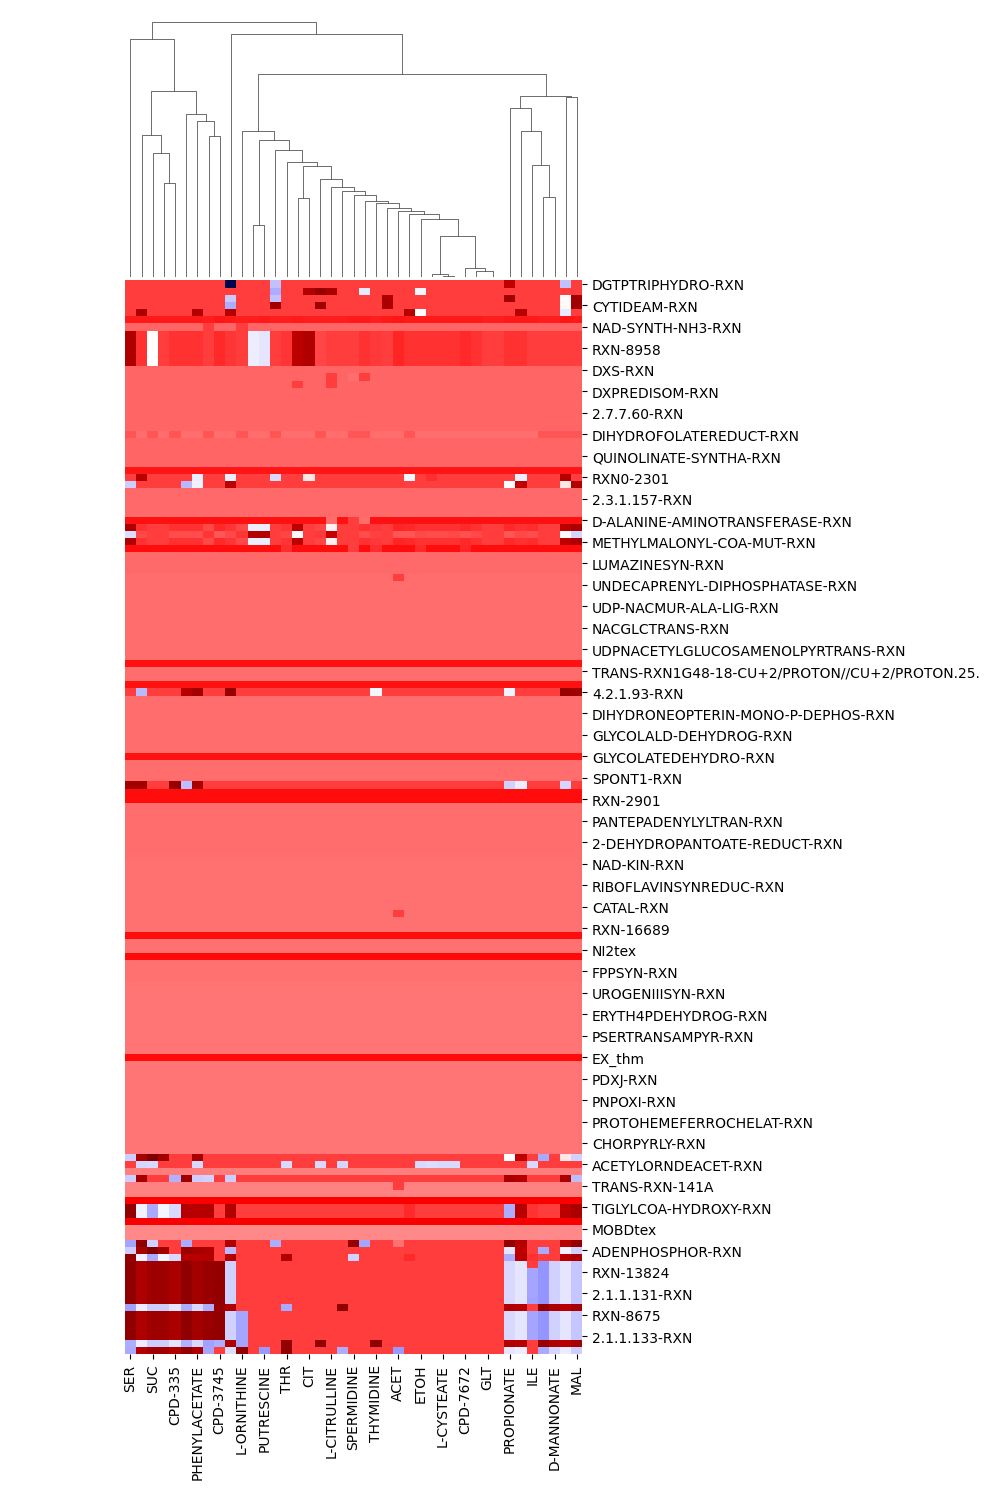

In [30]:
# Rough sketch - redo with better distance metric, method of determining fluxes, etc.

import seaborn as sns

solutions = {}

for subs in substrates[substrates["Model Growth"] > 0]["BIOCYC ID"]:
    if "," in subs:
        continue

    with model:
        met = model.metabolites.get_by_id(subs + "[c]")

        try:
            met_e = model.metabolites.get_by_id(f"{subs}[e]")
        except:
            met_e = Metabolite(f"{subs}[e]", name=subs, compartment="e")
            model.add_metabolites([met_e])
        ex_rxn = get_or_create_exchange(model, met_e.id)

        # Create transport reaction
        transport = Reaction("test", "", lower_bound=-1000, upper_bound=1000)
        transport.add_metabolites({
            met_e : -1,
            met : 1
        })
        model.add_reactions([transport])

        set_active_bound(ex_rxn, 10)
        sol = model.optimize()
        # print(f"{subs}: {sol.objective_value}")
    
    solutions[subs] = sol.fluxes / sol.objective_value

dat = pd.DataFrame(solutions)

# Drop all-zero rows
dat = dat.loc[:, (dat != 0).any(axis=0)]

# Replace zeroes with nan
dat = dat.replace(0, np.nan)

# Take symmetric log
dat = np.sign(dat) * np.log(np.abs(dat))

# Replace nan with zero
dat = dat.fillna(0)

# Sort by total flux
dat["total"] = dat.abs().sum(axis=1)
dat = dat.sort_values("total")
dat = dat.drop("total", axis=1)

# Keep top N rows by total flux
dat = dat[-150:]

sns.clustermap(dat, cmap=cmap, row_cluster=False, col_cluster=True, cbar_pos=None, figsize=(10, 15))

In [31]:
solutions

{'CPD-7672': 1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN    7.521400e-02
 1.1.1.178-RXN                          0.000000e+00
 1.1.1.262-RXN                          0.000000e+00
 1.1.1.39-RXN                           0.000000e+00
 1.1.1.8-RXN                            1.390280e-01
                                            ...     
 1.10.2.2-RXN                           1.884400e+02
 Citrate-transport                      0.000000e+00
 3-Hydroxybutyrate-transport           -7.779235e-15
 EX_CPD-7672[e]                        -4.334276e+01
 test                                   4.334276e+01
 Name: fluxes, Length: 1970, dtype: float64,
 'ACET': 1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN      0.075214
 1.1.1.178-RXN                            0.000000
 1.1.1.262-RXN                            0.000000
 1.1.1.39-RXN                             0.000000
 1.1.1.8-RXN                              0.139028
                                           ...    
 CYTOCHROME-C-OXIDASE-RXN               115.74

In [32]:
dat

,CPD-7672,ACET,L-ALPHA-ALANINE,ARG,L-ASPARTATE,CIT,L-CITRULLINE,L-CYSTEATE,CPD-12692,ECTOINE,...,PYRUVATE,SER,GLYCEROL-3P,SPERMIDINE,SUC,TAURINE,THR,THYMIDINE,TYR,CPD-335
DGTPTRIPHYDRO-RXN,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,-110.703722,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RXN-5882,0.0,0.000000,0.0,0.0,0.000000,33.930748,36.633437,0.0,0.000000,0.0,...,0.000000,0.000000,42.868722,0.0,0.000000,-33.980869,0.000000,0.000000,0.000000,0.000000
URACIL-PRIBOSYLTRANS-RXN,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,-38.472036,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CYTIDEAM-RXN,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,-43.016163,0.0,...,0.000000,0.000000,40.081320,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RXN-14264,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,32.868187,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,32.029115,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.1.1.130-RXN,0.0,0.000000,0.0,0.0,40.531966,0.000000,0.000000,0.0,-37.514348,0.0,...,44.767359,44.776221,0.000000,0.0,40.055789,0.000000,0.000000,0.000000,-34.410892,36.409068
R322-RXN,0.0,0.000000,0.0,0.0,40.531966,0.000000,0.000000,0.0,-37.514348,0.0,...,44.717743,44.776221,0.000000,0.0,40.055789,0.000000,0.000000,0.000000,-34.410892,36.409068
2.1.1.133-RXN,0.0,0.000000,0.0,0.0,40.531966,0.000000,0.000000,0.0,-37.514348,0.0,...,44.767359,44.776221,0.000000,0.0,40.055789,0.000000,0.000000,0.000000,-34.410892,36.409068
THI-P-KIN-RXN,0.0,0.000000,0.0,0.0,-38.466701,0.000000,0.000000,0.0,35.435362,0.0,...,-42.513619,-43.262150,43.717416,0.0,-37.987007,0.000000,44.212056,44.584588,32.334002,-34.329085


In [33]:
pathway

'UDPNAGSYN-PWY'

In [34]:
print(f"{model.reactions.get_by_id("EX_h")} glucose: {glc_fluxes["EX_h"]} \t acetate: {ace_fluxes["EX_h"]}")

EX_h: PROTON[e] <=>  glucose: 7.239471144520401 	 acetate: -68.72973315819308


In [35]:
print(f"{model.reactions.get_by_id("EX_nh4")} glucose: {glc_fluxes["EX_nh4"]} \t acetate: {ace_fluxes["EX_nh4"]}")
print(f"{model.reactions.get_by_id("NH4tex")} glucose: {glc_fluxes["NH4tex"]} \t acetate: {ace_fluxes["NH4tex"]}")

# print(f"{model.reactions.get_by_id("PYRtex")} glucose: {glc_fluxes["EX_pyr"]} \t acetate: {ace_fluxes["EX_pyr"]}")


EX_nh4: AMMONIUM[e] <=>  glucose: -7.41947302739428 	 acetate: -7.419473027388313
NH4tex: AMMONIUM[e] <=> AMMONIUM[p] glucose: 7.41947302739428 	 acetate: 7.419473027388313


In [ ]:
for rxn in [rxn for rxn in model.reactions if "PYRUVDEHYD-PWY" in rxn.notes.get("pathways", [])]:
    print(rxn)

In [37]:
model.reactions.get_by_id("PDH")

Reaction identifier,PDH
Name,Pyruvate dehydrogenase (NADH)
Memory address,0x7f184bb81610
Stoichiometry,CO-A[c] + NAD[c] + PYRUVATE[c] --> ACETYL-COA[c] + CARBON-DIOXIDE[c] + NADH[c] coenzyme A + NAD+ + pyruvate --> acetyl-CoA + CO2 + NADH
GPR,
Lower bound,0.0
Upper bound,1000.0


In [ ]:
model.reactions.get_by_id("6PFRUCTPHOS-RXN").notes

# Should be in glycolysis - why is it missing?

{'EC Number': '2.7.1.11',
 'Kegg ID': 'R00756',
 'stem': '6PFRUCTPHOS-RXN',
 'pathways': 'ANAGLYCOLYSIS-PWY'}

In [ ]:
# Sort pathways by total flux
pathway_fluxes = {}
for rxn in plot_fluxes.index:
    pwys = model.reactions.get_by_id(rxn).notes.get("pathways", [])
    if isinstance(pwys, str):
        pwys = [pwys]

    for pwy in pwys:
        if pwy not in pathway_fluxes:
            pathway_fluxes[pwy] = 0
        pathway_fluxes[pwy] += plot_fluxes.loc[rxn].sum()

df = pd.DataFrame({"flux": pathway_fluxes})
df.sort_values("flux", ascending=False).head(50)

,flux
GLUCONEO-PWY,94.887046
ARGSYNBSUB-PWY,6.121803
GLUTORN-PWY,4.591352
ARGSYN-PWY,4.591352
BRANCHED-CHAIN-AA-SYN-PWY,4.359495
VALSYN-PWY,4.359495
PWY-4381,3.614728
OXIDATIVEPENT-PWY,2.122850
PWY-6163,1.310211
PWY-6630,1.310211


In [40]:
PWY-3781  # aerobic respiration I (cytochrome c)
PWY-5741  # Ethylmalonyl-CoA pathway
PWY-7980  # ATP biosynthesis
PWY-8303  # reductive glycine pathway of autotrophic CO2 fixation
ANAGLYCOLYSIS-PWY  # Glycolysis
PROPIONMET-PWY  # propanoyl CoA degradation I
FAO-PWY  # fatty acid β-oxidation I (generic)
PWY0-1337  # oleate β-oxidation
GLUTDEG-PWY  # L-glutamate degradation II
1CMET2-PWY	# folate transformations III (E. coli)
PWY-1722  # formate assimilation into 5,10-methylenetetrahydrofolate
PWY-8004  # Entner-Doudoroff pathway I
PWY-1881  # formate oxidation to CO2
TCA
PWY-8291  # L-aspartate degradation II (aerobic)
PWY-6613  # tetrahydrofolate salvage from 5,10-methenyltetrahydrofolate
PWY0-1313  # acetate conversion to acetyl-CoA
PWY-8279  # palmitate biosynthesis III
PWY-8280  # stearate biosynthesis IV  (likely dupe of above)
PWY-7388  # octanoyl-[acyl-carrier protein] biosynthesis (mitochondria, yeast)
FASYN-ELONG-PWY  # fatty acid elongation -- saturated
SERSYN-PWY  # L-serine biosynthesis I
PWY-2161  # folate polyglutamylation
PWY1-3  # polyhydroxybutanoate biosynthesis
PYRIDOXSYN-PWY  # pyridoxal 5'-phosphate biosynthesis I
PHESYN  # L-phenylalanine biosynthesis I
TYRSYN  # L-tyrosine biosynthesis I
ASPARTATE-DEG1-PWY  # L-aspartate degradation I
PWY-6638  # sulfolactate degradation III
PWY-5329  # L-cysteine degradation III
PWY-5886  # 3-(4-hydroxyphenyl)pyruvate biosynthesis
GLYSYN-PWY  # glycine biosynthesis I
UDPNAGSYN-PWY  # UDP-N-acetyl-D-glucosamine biosynthesis I

# All below probably identical
PWY-5971  # palmitate biosynthesis II (type II fatty acid synthase)
PWY-6282  # palmitoleate biosynthesis I (from (5Z)-dodec-5-enoate)
PWY0-862   # (5Z)-dodecenoate biosynthesis I 
PWY-7664  # oleate biosynthesis IV (anaerobic)
PWY-7663  # gondoa biosynthesis (anaerobic)
PWY-8203  # 8-amino-7-oxononanoate biosynthesis IV 	
PWY-6163  # chorismate biosynthesis from 3-dehydroquinate

# Probably RXN0-5055?
PWY-4381  # fatty acid biosynthesis initiation (type II)
PWY0-1264  # biotin-carboxyl carrier protein assembly

SyntaxError: invalid decimal literal (265365928.py, line 10)

In [ ]:
model.reactions.get_by_id("GLYOHMETRANS-RXN")

Reaction identifier,GLYOHMETRANS-RXN
Name,GLYOHMETRANS-RXN
Memory address,0x7f867cc3fa40
Stoichiometry,"SER[c] + THF-GLU-N[c] <=> GLY[c] + METHYLENE-THF-GLU-N[c] + WATER[c] L-serine + a tetrahydrofolate <=> glycine + a 5,10-methylenetetrahydrofolate + H2O"
GPR,G1G48-3584 or G1G48-1604 or G1G48-2988
Lower bound,-1000.0
Upper bound,1000.0


In [ ]:
plot_fluxes.loc["GLYOHMETRANS-RXN"]

glc     5.846592
ace    14.333070
Name: GLYOHMETRANS-RXN, dtype: float64

In [24]:
comp = ["PROTEIN", "DNA", "RNA", "LIPID", "COFACTORS", "IONS", "MUREIN", "PHB-STORAGE"]
biomass = model.reactions.get_by_id("Rpom_hwa_biomass")

model.metabolites.get_by_id("PROTEIN[c]")

Metabolite identifier,PROTEIN[c]
Name,
Memory address,0x7f0c78d23620
Formula,None
Compartment,c
In 2 reaction(s),"PROTEIN-RXN, Rpom_hwa_biomass"
